In [13]:
import pickle

from gensim.models import Word2Vec
import lightgbm as lgb
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

from tqdm.auto import tqdm

In [2]:
df = pd.read_parquet('./data/featurized.parquet')
sorted_df = df.sort_values(by='msno').reset_index(drop=True)

In [3]:
del df

In [4]:
X = sorted_df.iloc[:, :-1]
y = sorted_df.iloc[:, -1]

## Word2Vec embeddings

In [5]:
def w2v_fit(df):
    # group positives by user id to create user to sentence mapping
    user2sentence = df[df['target'] == 1].groupby('msno')['song_id'].apply(list).to_dict()
    w2v = Word2Vec(vector_size=64, window=5)
    w2v.build_vocab(list(user2sentence.values()))
    w2v.train(list(user2sentence.values()), total_examples=w2v.corpus_count, epochs=10)
    return w2v


def get_song_embeddings(w2v):
    return pd.DataFrame(
        {'song_id': list(w2v.wv.key_to_index.keys()), 'song_emb': list(w2v.wv.vectors)}
    )

def get_user_embeddings(w2v, df):
    # User embedding is the mean of its positives' embeddings
    def get_user_embedding(sentence):
        sentence = [x_ for x_ in sentence if x_ in w2v.wv]
        if len(sentence) == 0:
            # Zeros if the user didn't like anything (can be replaced with mean embedding, for example)
            return np.zeros(w2v.vector_size)
        return np.mean(w2v.wv[sentence], axis=0)
    
    return pd.DataFrame(
        df[df['target'] == 1].groupby('msno')['song_id'].apply(get_user_embedding)
    ).reset_index().rename({'song_id': 'user_emb'}, axis=1)

def w2v_predict(w2v, df):
    song_embs = get_song_embeddings(w2v)
    user_embs = get_user_embeddings(w2v, df)
    
    out = df[['msno', 'song_id']]
    out = out.merge(song_embs, on='song_id', how='left').merge(user_embs, on='msno', how='left')
    
    song_embs = np.array(
        [e if not np.isnan(e).any() else np.full(w2v.vector_size, np.nan) for e in out['song_emb'].tolist()]
    )
    user_embs = np.array(
        [e if not np.isnan(e).any() else np.full(w2v.vector_size, np.nan) for e in out['user_emb'].tolist()]
    )
    out.drop(['song_emb', 'user_emb'], axis=1, inplace=True)
    # Dot product
    out['pred'] = np.sum(song_embs * user_embs, axis=1)
    # Fill NaN predictions with median
    out['pred'] = out['pred'].fillna(out['pred'].median())
    # Rescale for ROC-AUC computation
    out['pred'] = (out['pred'] - out['pred'].min()) / (out['pred'].max() - out['pred'].min())
    return out['pred'].values

In [7]:
w2v = w2v_fit(sorted_df)

In [8]:
songs = pd.read_csv('./data/songs.csv')

In [9]:
def get_similars_for_song(idx: int):
    if songs.song_id[idx] in w2v.wv:
        return songs[np.isin(songs.song_id, list(map(lambda x: x[0], w2v.wv.similar_by_key(songs.song_id[idx]))))]

In [12]:
songs.head(2)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0


In [10]:
# Looks reasonable
get_similars_for_song(0)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
9528,TkWth1rei/T7vSZ3PMx9FNlvZVb6v71itij/Tl7YQXU=,253097,465,李翊君．許茹芸．許美靜,Masaaki Hiro| Rei Nakanishi,NaN,3.0
64283,m1ooG9GWPztHGlIcN4duM8N27Kgq+qzuLzQjZrWae50=,273414,465,內地華語精選,NaN,NaN,3.0
69704,Ne3gt5pb1Po6yrMD17GdSmPsrDt4ze0wXPWVnOzqqJk=,341002,465,王傑 (Dave Wang),Wang Chieh,Zhang Fan-Lu,3.0
108696,o7ns0pR+JM+01ZvelRJ0HdLbYFk3As/uc2DCspcpglc=,234057,465,任賢齊 (Richie Jen),NaN,NaN,3.0
168176,aKxjhLqjmZe926no2SmSa7krH30IBVcafnoQ19En07M=,276845,465,戴梅君,郭之儀,郭之儀,10.0
526815,RtXifchS0iqhzcabF5+9fTOmZS5vmWyX9XGADpJVuPM=,221518,465,卓文萱 (Genie Zhuo),CSHA,CSHA+洪嘉濃,3.0
605286,MIsT4C5VzofCGUpRKfYcOGD+gN+qQ+wZ/dMNRLAVf6g=,334889,465,張信哲 (Jeff Chang),NaN,NaN,3.0
847325,Sh1IbM0v8W3z5B6f1yW7qfY7QJQUgAC1R+1PzGCv5Uk=,158592,465,容祖兒 (Joey Yung),顧嘉煇,黃霑,24.0
1939855,SWcqvgEYQaBNYbATqM1Z6Q8+lfJkc2/n0ArbX9xpPTU=,218174,947,黃思婷,NaN,NaN,3.0
1940196,1i5w42MUqYKRAEbMc9Od6bTtOoWu3lbNv23HXmHfxpM=,241267,873,蕭煌奇 (Ricky Hsiao),蓮歌子,蓮歌子,-1.0


In [11]:
# Same here
get_similars_for_song(1)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
41493,yv4Nasbw8r06KtMHzaEMF/SrpYPv+V73JrwFClUoRQ0=,221982,444,Taeyeon,Bong Eun Young|Yu Jin Lee|Mafly|Matthew Tishle...,NaN,31.0
57537,IhNTvk4edMSv0PCLIS6Ry23aEYtKEA/KwbJNi1OV84A=,206007,465,Taeyeon,NaN,NaN,31.0
57541,OCf6ja6rohWVy5UBE/XTSOf9YxiMrkCIaLTkFQ+nNf8=,212453,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY| Bekuh BOOM,31.0
93670,0PSoBhrpfwF09qQKvTiItwZNPjOuyL0uoTazKevG8ls=,223375,444,Taeyeon,Kim Ea Na| Christian Vinten| Chelcee Grimes,NaN,31.0
95000,uzU6ntNZT60j0CqFNXTpF6Oo8W3w5UwU/ANEODidW04=,208793,444,TWICE,Black Eyed V,NaN,31.0
96339,JuOOeJJjt5Dgbug0czZ6Mv25AJMtVAukaoxz8T/JX7c=,230373,444,BLACKPINK,TEDDY| SEO WON JIN,TEDDY,31.0
123099,w4Zku7HxtkAKl/BB8H81ZfWOXwnnmVbZBvFZeRPuRUU=,216967,444,BANGTAN BOYS,"Pdogg| Rap Monster| Suga| J-hope| ""hitman""bang...",NaN,31.0
287598,rcPNzl8xjj74tjZDop961+ugDVJKx4mdgh7L1xJ85FI=,240822,444,BLACKPINK,TEDDY| Bekuh BOOM,TEDDY| Bekuh BOOM,31.0
333096,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,229982,465,BIGBANG TAEYANG,TEDDY| DEE.P| Rebecca Johnson,TEDDY| TAEYANG,31.0
1401790,kE+FVLsG03zTzYoGVDqTmVkoSKC9DjJwQr2puF6MkOI=,211670,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY| Bekuh BOOM,31.0


## Word2Vec as a predictor model

In [15]:
# 5 fold CV
preds = np.zeros_like(y, dtype=float)
models = []
for train_idx, test_idx in tqdm(GroupKFold(5).split(X, y, sorted_df['msno']), total=5):
    w2v = w2v_fit(sorted_df.iloc[train_idx])
    preds[test_idx] = w2v_predict(w2v, sorted_df.iloc[test_idx])

  0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
# OOF ROC-AUC
roc_auc_score(y, preds)

0.5854771769051105

In [17]:
def mean_user_auc(y_true, y_pred, group):
    out = 0.
    i = 0
    valid_user_count = 0
    for j in np.cumsum(group):
        if j - i < 2 or len(set(y_true[i:j])) < 2:
            continue
        out += roc_auc_score(y_true[i:j], y_pred[i:j])
        valid_user_count += 1
        i = j
    out /= valid_user_count
    
    return out

In [21]:
# Mean User ROC-AUC
mean_user_auc(y, preds, sorted_df.groupby('msno')['song_id'].count().tolist())

0.6777159508064032

Интересно, что по обычному ROC-AUC LGBM сильно лучше (~0.8), однако по Mean User AUC впереди эмбеддинги Word2Vec.
Скорее всего такое поведение обуславливается извлеченными фичами. Word2Vec учитывает частоты для песен, юзеров, а LGBM использует более "глобальные" фичи, вроде имен исполнителей, композиторов, длительности трека и т.д.

## Ensembling

In [48]:
def lgb_mean_user_auc(y_pred, train_data):
    out = mean_user_auc(train_data.label, y_pred, train_data.group)
    return 'mean_user_auc', out, True


def train_lgb_w2v_blend(df, params):
    X = df.iloc[:, :-1]
    groups = df.iloc[:, 0]
    y = df.iloc[:, -1]
    
    preds = np.zeros_like(y, dtype=float)
    models = []
    test_sets = []
    
    for train_idx, test_idx in GroupKFold(5).split(X, y, groups):
        train_group = groups.iloc[train_idx].groupby(groups.iloc[train_idx].values).count().tolist()
        test_group = groups.iloc[test_idx].groupby(groups.iloc[test_idx].values).count().tolist()
        
        w2v = w2v_fit(sorted_df.iloc[train_idx])
        w2v_train = w2v_predict(w2v, sorted_df.iloc[train_idx])
        w2v_test = w2v_predict(w2v, sorted_df.iloc[test_idx])
        
        X_train = X.iloc[train_idx, 1:].copy()
        X_train['w2v'] = w2v_train
        X_test = X.iloc[test_idx, 1:].copy()
        X_test['w2v'] = w2v_test
        
        train_ds = lgb.Dataset(X_train, y.iloc[train_idx], group=train_group)
        test_ds = lgb.Dataset(X_test, y.iloc[test_idx], group=test_group)
        
        test_sets.append((X_test, y.iloc[test_idx]))

        # We can use early stopping because of the holdout set existence ("./data/test.csv")
        # In a real world application we would tune the model on a CV and 
        # measure the best model performance on the holdout
        # However, 100 boosting rounds is too few and the model is still underfit
        model = lgb.train(
            params, 
            train_set=train_ds, 
            valid_sets=test_ds, 
            fobj=None, 
            feval=lgb_mean_user_auc, 
            verbose_eval=5, 
            early_stopping_rounds=25
        )
        models.append((model, w2v))
        preds[test_idx] = model.predict(X_test)
        
    return preds, models, test_sets

In [49]:
# LGB params from kaggle, slightly modified
params = {
    'objective': 'lambdarank',
    'metric': 'None',
    'boosting': 'gbdt',
    'learning_rate': 0.2 ,
    'verbose': 0,
    'num_leaves': 100,
    'bagging_fraction': 0.95,
    'bagging_freq': 1,
    'bagging_seed': 1,
    'feature_fraction': 0.9,
    'feature_fraction_seed': 1,
    'max_bin': 256,
    'num_rounds': 50,
}

In [50]:
preds, models, test_sets = train_lgb_w2v_blend(sorted_df, params)

Found `num_rounds` in params. Will use it instead of argument
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.316467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 25 rounds
[5]	valid_0's mean_user_auc: 0.698387
[10]	valid_0's mean_user_auc: 0.709179
[15]	valid_0's mean_user_auc: 0.714894
[20]	valid_0's mean_user_auc: 0.717236
[25]	valid_0's mean_user_auc: 0.719265
[30]	valid_0's mean_user_auc: 0.720678
[35]	valid_0's mean_user_auc: 0.72157
[40]	valid_0's mean_user_auc: 0.722445
[45]	valid_0's mean_user_auc: 0.722743
[50]	valid_0's mean_user_auc: 0.72315
Did not meet early stopping. Best iteration is:
[49]	valid_0's mean_user_auc: 0.723151


Found `num_rounds` in params. Will use it instead of argument
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.349741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 25 rounds
[5]	valid_0's mean_user_auc: 0.700796
[10]	valid_0's mean_user_auc: 0.711108
[15]	valid_0's mean_user_auc: 0.7171
[20]	valid_0's mean_user_auc: 0.719794
[25]	valid_0's mean_user_auc: 0.721951
[30]	valid_0's mean_user_auc: 0.72389
[35]	valid_0's mean_user_auc: 0.724992
[40]	valid_0's mean_user_auc: 0.725972
[45]	valid_0's mean_user_auc: 0.726458
[50]	valid_0's mean_user_auc: 0.727001
Did not meet early stopping. Best iteration is:
[50]	valid_0's mean_user_auc: 0.727001


Found `num_rounds` in params. Will use it instead of argument
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.495053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 25 rounds
[5]	valid_0's mean_user_auc: 0.703101
[10]	valid_0's mean_user_auc: 0.713127
[15]	valid_0's mean_user_auc: 0.719673
[20]	valid_0's mean_user_auc: 0.722696
[25]	valid_0's mean_user_auc: 0.724813
[30]	valid_0's mean_user_auc: 0.7266
[35]	valid_0's mean_user_auc: 0.728
[40]	valid_0's mean_user_auc: 0.728753
[45]	valid_0's mean_user_auc: 0.729203
[50]	valid_0's mean_user_auc: 0.729772
Did not meet early stopping. Best iteration is:
[50]	valid_0's mean_user_auc: 0.729772


Found `num_rounds` in params. Will use it instead of argument
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.389359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 25 rounds
[5]	valid_0's mean_user_auc: 0.703219
[10]	valid_0's mean_user_auc: 0.714484
[15]	valid_0's mean_user_auc: 0.719873
[20]	valid_0's mean_user_auc: 0.722494
[25]	valid_0's mean_user_auc: 0.72494
[30]	valid_0's mean_user_auc: 0.726294
[35]	valid_0's mean_user_auc: 0.727207
[40]	valid_0's mean_user_auc: 0.727982
[45]	valid_0's mean_user_auc: 0.728223
[50]	valid_0's mean_user_auc: 0.728347
Did not meet early stopping. Best iteration is:
[49]	valid_0's mean_user_auc: 0.72858


Found `num_rounds` in params. Will use it instead of argument
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.346056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 25 rounds
[5]	valid_0's mean_user_auc: 0.687899
[10]	valid_0's mean_user_auc: 0.695352
[15]	valid_0's mean_user_auc: 0.701305
[20]	valid_0's mean_user_auc: 0.702967
[25]	valid_0's mean_user_auc: 0.707049
[30]	valid_0's mean_user_auc: 0.706428
[35]	valid_0's mean_user_auc: 0.704567
[40]	valid_0's mean_user_auc: 0.703479
[45]	valid_0's mean_user_auc: 0.701518
[50]	valid_0's mean_user_auc: 0.70105
Early stopping, best iteration is:
[25]	valid_0's mean_user_auc: 0.707049


In [51]:
# OOF ROC-AUC
roc_auc_score(y, preds)

0.6731416659613457

In [52]:
# Mean User ROC-AUC
mean_user_auc(y, preds, sorted_df.groupby('msno')['song_id'].count().tolist())

0.7235707459160624

Блендингом Word2Vec-а с LGBM, удалось улучшить обе метрики

In [53]:
import shap

In [54]:
explainer = shap.TreeExplainer(models[0][0])

In [55]:
out = explainer.shap_values(*test_sets[0])

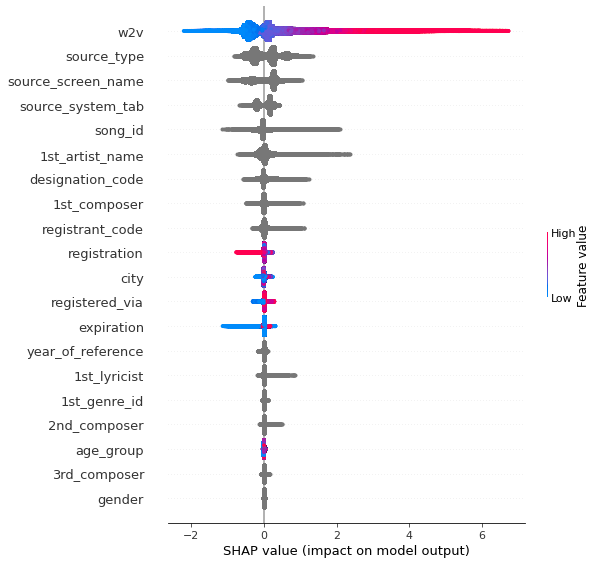

In [56]:
shap.summary_plot(out, test_sets[0][0])

Хотел посчитать out-of-fold shap values, но, к сожалению, это занимает очень много времени, поэтому оставлю для одного фолда. Вряд ли мы увидим сильно отличающиеся результаты на остальных фолдах, так как у нас немного фич и метрики на фолдах довольно близки

Видно, что предсказание Word2Vec полезно, так как оно стало самой важной фичей. Опять же, скорее всего, потому что фичи для LGBM и фичи из Word2Vec сильно отличаются, а значит последние докидывают информацию 